# Numbered Empirical Data Generation

Synthetic data derived from gamma distributions appear to be well-behaved. It is noted that despite iid sampling, conditing average middle fixation durations yields well-defined value-modulated effects. As a result, we set out to change the architecture of the empirical distributions object. Instead of binning fixations based on fixated and unfixated value difference, we will follow Eum et al. (2023) in their synthetic data generation. Empirical distributions will just have pooled distributions from first fixations, second fixations, and so on. Once constructed, this object will generate data following methodology from `empirical_addm_gen_data.ipynb`.

### Loading data

In [1]:
import os, sys

DDM_dir = os.path.abspath('/Users/braydenchien/Desktop/Enkavilab/DDM')
sys.path.append(DDM_dir)

dt = 0.001

In [2]:
from simulation import get_corrected_numbered_empirical_distributions
from ast import literal_eval
import numpy as np
import pandas as pd

df_raw = pd.read_csv('/Users/braydenchien/Desktop/Enkavilab/DDM/1ms_trial_data.csv')
df_raw['choice'] = df_raw['choice'].map({'left':0,'right':1})
df_raw['RT'] = df_raw['RT'] / dt # adjustment for RT
df_raw['fixation'] = df_raw['fixation'].apply(literal_eval)

to_drop = pd.read_csv("/Users/braydenchien/Desktop/Enkavilab/DDM/dropped_trials.csv").rename(columns={"parcode": "sub_id"})

df = df_raw[
    ~df_raw.set_index(["sub_id", "trial"]).index.isin(
        to_drop.set_index(["sub_id", "trial"]).index
    )
]

num_data, _ = df.shape

value_diffs = np.unique(df['avgWTP_left'] - df['avgWTP_right'])
legend = {
    "left": {1},
    "right": {2},
    "transition": {0}, 
    "blank_fixation": {4}
}
fixation_col = 'fixation'
left_value_col = 'avgWTP_left'
right_value_col = 'avgWTP_right'

empirical_distributions = get_corrected_numbered_empirical_distributions(
    df,
    legend=legend,
    fixation_col=fixation_col,
    cutoff=0.9
)

### Simulating data

In [ ]:
# Defining constants
a, b = 1, 0
eta = 0.5
kappa = 2
T = 25 / dt
x0 = 0
sigma = 0.7 

# r1_data = np.zeros(num_data)
# r2_data = np.zeros(num_data)
r1_data = df['avgWTP_left'].to_numpy()
r2_data = df['avgWTP_right'].to_numpy()
# r1_data = [3]*num_data
# r2_data = [3]*num_data

seeds = np.random.SeedSequence(123).spawn(num_data)

In [4]:
from joblib import Parallel, delayed, cpu_count, dump, load
from data_utils import simulate_numbered_empirical_trial
import time

print("Available jobs:", cpu_count())

start = time.time()

dump(empirical_distributions, "empirical.mmap")
empirical_distributions = load("empirical.mmap", mmap_mode="r")


results = Parallel(n_jobs=-1, backend="loky")(
    delayed(simulate_numbered_empirical_trial)(
        n,
        r1_data,
        r2_data,
        empirical_distributions,
        eta=eta,
        kappa=kappa,
        sigma=sigma,
        a=a,
        b=b,
        T=T,
        x0=x0,
        dt=dt,
        seed=seeds[n]
    )
    for n in range(num_data)
)

print(f"Elapsed time: {time.time() - start:.3f} seconds")

# Store results
decision_data = np.zeros((num_data, 2))
flag_data = np.zeros(num_data)
mu_data = [None] * num_data
sacc_data = [None] * num_data

for n, (decision, mu_array, sacc_array, r1, r2, flag) in enumerate(results):
    decision_data[n] = decision
    mu_data[n] = mu_array
    sacc_data[n] = sacc_array
    r1_data[n] = r1
    r2_data[n] = r2
    flag_data[n] = flag

Available jobs: 8
Elapsed time: 176.622 seconds


### Model independent analysis

In [5]:
from data_utils import expand_addm_fixations

rt_data = decision_data[:, 0].astype(np.float64)
choice_data = decision_data[:, 1].astype(np.int32)
expanded_fixations = expand_addm_fixations(sacc_data, flag_data, rt_data, dt)

efpt_df = pd.DataFrame({
    'sub_id': 'empirical_efpt',
    'trial': range(1, num_data + 1),
    'avgWTP_left': r1_data,
    'avgWTP_right': r2_data,
    'choice': (1 - choice_data) // 2,
    'RT': rt_data * 1000,
    'fixation': expanded_fixations
})

efpt_df.head()

,sub_id,trial,avgWTP_left,avgWTP_right,choice,RT,fixation
0,empirical_efpt,1,1.00,5.0,1,153.5,"(0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
1,empirical_efpt,2,3.00,5.0,1,202.5,"(0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
2,empirical_efpt,3,4.25,1.0,0,866.5,"(0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
3,empirical_efpt,4,3.50,1.0,0,689.5,"(0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
4,empirical_efpt,5,1.50,1.0,0,939.5,"(0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."


In [6]:
np.mean(efpt_df['RT'])

np.float64(663.7410171660002)

In [7]:
from data_utils import rasterize_data

efpt_rasterized = rasterize_data(efpt_df, subject_col='sub_id',trial_col='trial',seq_col='fixation')
efpt_rasterized = efpt_rasterized.loc[:, ['sub_id', 'trial', 'avgWTP_left', 'avgWTP_right', 'choice', 'RT', 'fix_start', 'fix_end', 'fix_location']]
efpt_rasterized['fix_dur'] = efpt_rasterized.apply(
    lambda r: r['fix_end'] - r['fix_start'],
    axis=1
)

efpt_rasterized['fix_num'] = (
    efpt_rasterized
    .groupby(['sub_id', 'trial'])
    .cumcount() + 1
)

efpt_rasterized['fix_num_rev'] = (
    efpt_rasterized
    .groupby(['sub_id', 'trial'])
    .cumcount(ascending=False) + 1
)
efpt_rasterized.head()

,sub_id,trial,avgWTP_left,avgWTP_right,choice,RT,fix_start,fix_end,fix_location,fix_dur,fix_num,fix_num_rev
0,empirical_efpt,1,1.00,5.0,1,153.5,70,154,1,84,1,1
1,empirical_efpt,2,3.00,5.0,1,202.5,70,203,2,133,1,1
2,empirical_efpt,3,4.25,1.0,0,866.5,240,842,2,602,1,2
3,empirical_efpt,3,4.25,1.0,0,866.5,848,867,1,19,2,1
4,empirical_efpt,4,3.50,1.0,0,689.5,142,638,1,496,1,2


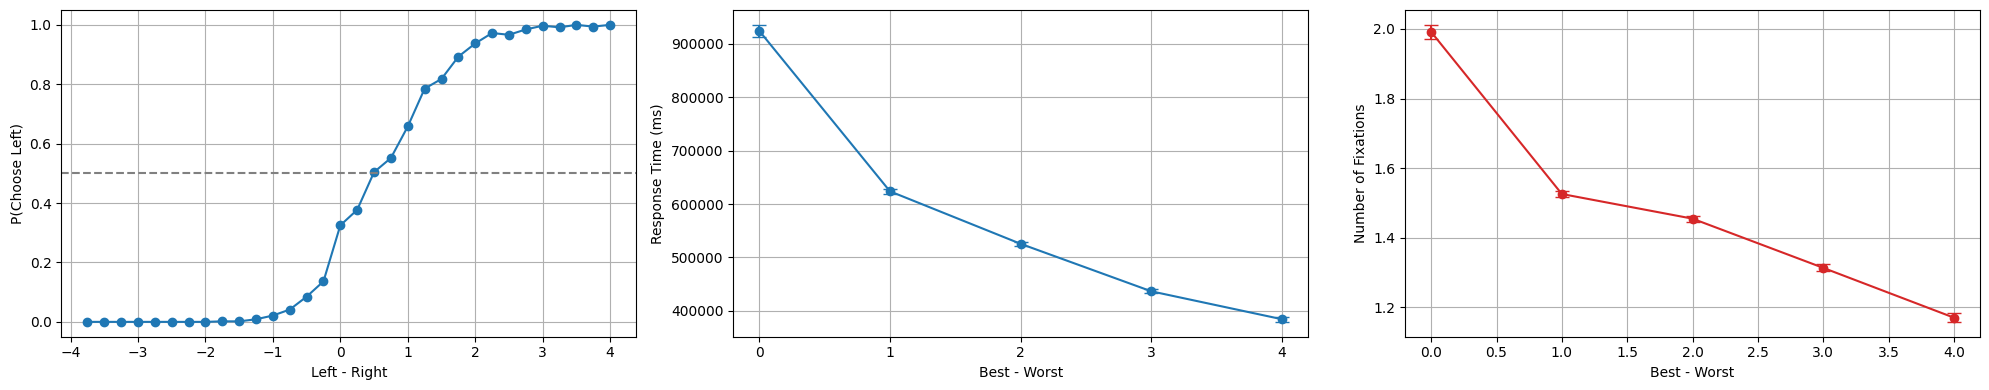

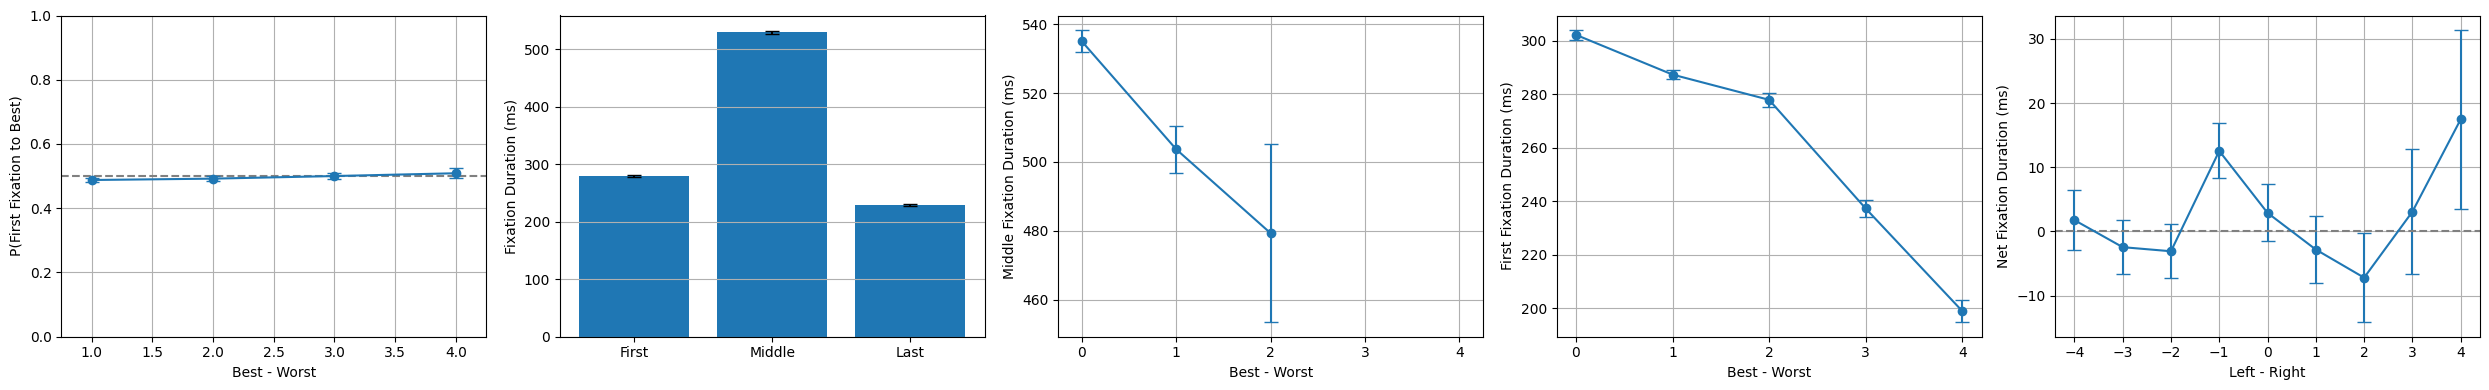

In [8]:
from mfa import plot_basic_psychometrics, plot_fixation_properties

plot_basic_psychometrics(efpt_rasterized)
plot_fixation_properties(efpt_rasterized)